In [275]:

import numpy as np
import pandas as pd
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
import datetime
import glob
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.core import datetools
from pandas import Series, DataFrame, Panel
from datetime import datetime

%matplotlib inline

##set the outputs to display only two decimal places - a global setting
pd.options.display.float_format = '{:.2f}'.format

In [149]:
## Import the flow gauge data to the notebook

Obs_gauges=pd.read_csv("C:/CRPL/0064_QLD_Water_Modelling_Network/Tully/Gauge_Data/TJ_Gauges_ML-d.csv",parse_dates=['Date'])


In [150]:
#Now make the dates column as the index so we can do time series plots and analysis on it
Obs_gauges.index = Obs_gauges.Date

# Remove the Date column from the data columns
del Obs_gauges['Date']

# get some basic stats on the whole gauge dataframe
Obs_gauges.describe()

,112002A Discharge (ML/day),112002A Quality,112101B Discharge (ML/day),112101B quality,112004A Discharge (ML/day),112004A Quality,113004A Discharge (ML/day),113004A Quality,113006A Discharge (ML/day),113006A Quality,113007A Discharge (ML/day),113007A Quality,113015A Discharge (ML/day),113015A Quality
count,15563.00,17631.00,15740.00,17631.00,17357.00,17631.00,16403.00,17631.00,14364.00,17631.00,10225.00,17631.00,3012.00,17631.00
mean,76.14,28.39,2217.95,42.88,5122.31,18.58,471.98,30.65,8627.72,41.39,257.01,82.35,2616.99,129.77
std,121.77,49.47,4000.36,75.49,9168.15,33.84,792.00,63.19,11570.73,59.75,604.54,82.59,3533.03,48.49
min,0.86,9.00,147.22,9.00,261.63,9.00,25.12,9.00,336.33,9.00,0.80,9.00,127.39,10.00
25%,20.84,9.00,654.07,9.00,1348.88,9.00,127.63,9.00,2646.93,9.00,32.18,9.00,1056.03,151.00
50%,43.20,9.00,1189.91,9.00,2661.42,9.00,254.06,9.00,4794.84,9.00,95.55,30.00,2025.00,151.00
75%,95.34,10.00,2300.32,20.00,5345.02,10.00,500.07,10.00,9348.82,20.00,266.87,151.00,2938.62,151.00
max,4007.22,255.00,86810.09,255.00,253610.40,255.00,16070.42,255.00,90327.06,255.00,26604.55,255.00,62395.02,255.00


In [151]:
## Import the modelled data corresponding to gauge sites to the notebook

Mod_gauges=pd.read_csv("C:/CRPL/0064_QLD_Water_Modelling_Network/Tully/Modelled_Flows_ML-d.csv",parse_dates=['Date'])

In [152]:
#Now make the dates column as the index so we can do time series plots and analysis on it
Mod_gauges.index = Mod_gauges.Date

# Remove the Date column from the data columns
del Mod_gauges['Date']

# get some basic stats on the whole modelled time series dataframe
Mod_gauges.describe()

,1120049 Modelled ML/d,112101B Modelled ML/d,112102A Modelled ML/d,113004A Modelled ML/d,113007A Modelled ML/d,113015A Modelled ML/d,112004A Modelled ML/d,1120054 Modelled ML/d,113006A Modelled ML/d
count,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00
mean,5274.91,2231.05,435.36,458.99,111.56,2441.96,5000.35,9278.82,8247.06
std,8429.76,3700.73,753.72,730.70,283.26,2801.16,8213.98,14107.90,10864.60
min,0.00,0.00,0.00,0.00,0.00,20.82,0.00,0.00,0.00
25%,1466.51,682.47,102.12,124.62,17.14,1205.99,1382.73,2659.63,2420.99
50%,2968.34,1297.46,220.54,254.69,53.80,1770.65,2784.07,5335.10,5116.10
75%,5772.65,2344.02,458.87,497.73,127.91,2849.81,5439.57,10196.75,9576.11
max,211003.40,81233.59,16773.48,15611.77,9985.78,46855.35,209248.42,302837.52,117516.70


In [153]:
# Load in the APSIM Dates to append to the time series dataframes
APSIMDates=pd.read_csv("C:/CRPL/0064_QLD_Water_Modelling_Network/Tully/APSIMDates.csv",parse_dates=['Date'])

In [154]:
#Combine the APSIM drainage into a single dataframe
# get data drainage file names
path =r'C:\CRPL\0064_QLD_Water_Modelling_Network\Tully\Raw_Accummulated_APSIM'
filenames = glob.glob(path + "/*Drainage.csv")

#save out the drainage file name list
#DrainageFiles = glob.glob("*Drainage.csv")
DrainageFiles = [os.path.basename(x) for x in glob.glob(path + "/*Drainage.csv")]
np.savetxt("C:/CRPL/0064_QLD_Water_Modelling_Network/Tully/DrainageNames.csv", DrainageFiles, delimiter=",", fmt='%s')


drainagedfs = []
for filename in filenames:
    drainagedfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame on the date axis
Drainage = pd.concat(drainagedfs, axis=1)

#remove all the date columns
DrainageData=Drainage.drop(Drainage.columns[[2, 4, 6]], axis=1)

#Rename the columns according to the file names so we dont get confused on which file is which
DrainageData.columns = [DrainageFiles]

#Append one column of dates back on to the data file to make the time series file
DrainageTimeseries = pd.concat([APSIMDates, DrainageData], axis=1)

#Now make the dates column as the index so we can do time series plots and analysis on it
DrainageTimeseries.index = DrainageTimeseries.Date

#export the drainage time series file with the dates column to CSV
DrainageTimeseries.to_csv("C:/CRPL/0064_QLD_Water_Modelling_Network/Tully/DrainageTimeseries_mm-d.csv", index=False)

# Remove the Date column from the data columns
del DrainageTimeseries['Date']


In [155]:
#Combine the APSIM runoff into a single dataframe
# get data runoff file names
path =r'C:\CRPL\0064_QLD_Water_Modelling_Network\Tully\Raw_Accummulated_APSIM'
rfilenames = glob.glob(path + "/*runoff.csv")

#save out the runoff file name list
RunoffFiles = DrainageFiles = [os.path.basename(x) for x in glob.glob(path + "/*runoff.csv")]
np.savetxt("C:/CRPL/0064_QLD_Water_Modelling_Network/Tully/RunoffNames.csv", RunoffFiles, delimiter=",", fmt='%s')

runoffdfs = []
for rfilename in rfilenames:
    runoffdfs.append(pd.read_csv(rfilename))

# Concatenate all data into one DataFrame on the date axis
Runoff = pd.concat(runoffdfs, axis=1)

#remove all the date columns
RunoffData=Runoff.drop(Runoff.columns[[2, 4, 6]], axis=1)

#Rename the columns according to the file names so we dont get confused on which file is which
RunoffData.columns = [RunoffFiles]

#Append one column of dates back on to the data file to make the time series file
RunoffTimeseries = pd.concat([APSIMDates, RunoffData], axis=1)

#Now make the dates column as the index so we can do time series plots and analysis on it
RunoffTimeseries.index = RunoffTimeseries.Date

#export the drainage time series file with the dates column to CSV
RunoffTimeseries.to_csv("C:/CRPL/0064_QLD_Water_Modelling_Network/Tully/RunoffTimeseries_mm-d.csv", index=False)

# Remove the Date column from the data columns
del RunoffTimeseries['Date']


In [156]:
# Quick check of the drainage data
DrainageTimeseries.describe()

,"(SC #102$sugarcane$Drainage.csv,)","(SC #119$sugarcane$Drainage.csv,)","(SC #121$sugarcane$Drainage.csv,)","(SC #123$sugarcane$Drainage.csv,)","(SC #124$sugarcane$Drainage.csv,)","(SC #125$sugarcane$Drainage.csv,)","(SC #126$sugarcane$Drainage.csv,)","(SC #131$sugarcane$Drainage.csv,)","(SC #132$sugarcane$Drainage.csv,)","(SC #134$sugarcane$Drainage.csv,)",...,"(SC #479$sugarcane$Drainage.csv,)","(SC #482$sugarcane$Drainage.csv,)","(SC #484$sugarcane$Drainage.csv,)","(SC #485$sugarcane$Drainage.csv,)","(SC #487$sugarcane$Drainage.csv,)","(SC #90498$sugarcane$Drainage.csv,)","(SC #90500$sugarcane$Drainage.csv,)","(SC #90501$sugarcane$Drainage.csv,)","(SC #90502$sugarcane$Drainage.csv,)","(SC #90512$sugarcane$Drainage.csv,)"
count,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,...,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00
mean,6.53,4.62,5.67,4.79,4.92,4.42,5.26,5.58,5.60,4.46,...,1.32,3.36,2.64,2.58,3.60,5.79,5.15,5.10,3.21,3.37
std,10.40,5.64,8.63,7.98,7.33,6.60,8.50,9.60,8.71,5.79,...,2.02,4.15,3.30,3.14,4.52,8.03,7.48,8.04,3.62,4.16
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.75,0.50,0.38,0.36,0.47,0.33,0.43,0.48,0.28,0.33,...,0.00,0.20,0.04,0.04,0.28,0.22,0.57,0.12,0.26,0.34
50%,3.49,3.16,2.91,2.16,2.59,2.12,2.60,2.57,2.76,2.51,...,0.25,1.60,0.88,0.91,1.74,2.23,2.23,1.33,1.99,2.21
75%,7.18,7.12,8.31,6.58,6.66,6.83,6.59,6.47,8.27,7.09,...,1.78,5.70,5.08,5.18,5.90,8.12,6.93,6.91,5.67,5.20
max,50.00,31.38,49.92,49.46,40.96,47.19,48.39,49.98,49.94,45.00,...,8.93,29.09,15.37,13.24,44.96,53.27,52.01,51.44,20.35,30.07


In [157]:
#Quick check of the runoff data
RunoffTimeseries.describe()

,"(SC #102$sugarcane$Runoff.csv,)","(SC #119$sugarcane$Runoff.csv,)","(SC #121$sugarcane$Runoff.csv,)","(SC #123$sugarcane$Runoff.csv,)","(SC #124$sugarcane$Runoff.csv,)","(SC #125$sugarcane$Runoff.csv,)","(SC #126$sugarcane$Runoff.csv,)","(SC #131$sugarcane$Runoff.csv,)","(SC #132$sugarcane$Runoff.csv,)","(SC #134$sugarcane$Runoff.csv,)",...,"(SC #479$sugarcane$Runoff.csv,)","(SC #482$sugarcane$Runoff.csv,)","(SC #484$sugarcane$Runoff.csv,)","(SC #485$sugarcane$Runoff.csv,)","(SC #487$sugarcane$Runoff.csv,)","(SC #90498$sugarcane$Runoff.csv,)","(SC #90500$sugarcane$Runoff.csv,)","(SC #90501$sugarcane$Runoff.csv,)","(SC #90502$sugarcane$Runoff.csv,)","(SC #90512$sugarcane$Runoff.csv,)"
count,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,...,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00,10408.00
mean,2.37,2.88,1.59,1.66,2.18,1.99,1.95,1.61,1.66,2.50,...,1.24,2.86,2.91,2.93,3.05,1.29,1.50,0.82,2.57,2.94
std,14.76,14.27,11.82,12.55,12.93,13.14,13.08,11.88,12.26,13.69,...,8.19,14.57,16.15,16.28,14.05,10.40,10.27,8.02,13.37,14.40
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.04,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.02,...,0.00,0.01,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.01
max,312.44,254.72,278.93,351.20,332.31,353.27,327.91,329.47,251.88,273.81,...,239.22,267.77,366.89,363.66,307.62,336.21,276.86,338.11,384.42,388.55


In [158]:
#print(DrainageTimeseries.head(5))

#placeholder for more stuff later

(725007.0, 735414.0)

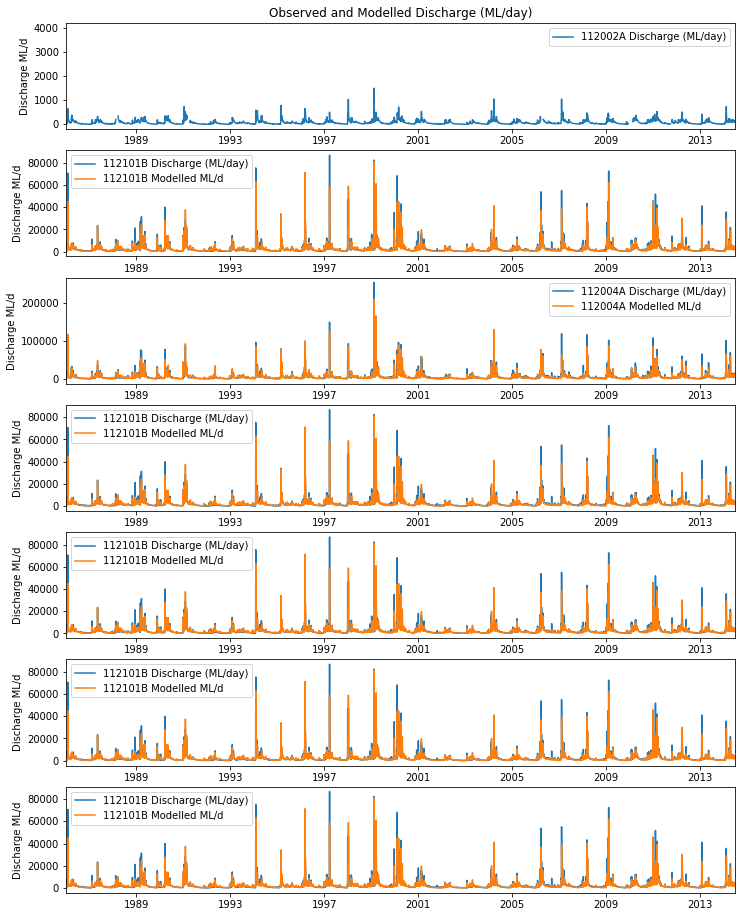

In [159]:
# Create a basic time series plots of the observed and gauged data and show it

G112002A = Obs_gauges['112002A Discharge (ML/day)']
G112101B = Obs_gauges['112101B Discharge (ML/day)']
G112004A = Obs_gauges['112004A Discharge (ML/day)']
G113004A = Obs_gauges['113004A Discharge (ML/day)']
G113006A = Obs_gauges['113006A Discharge (ML/day)']
G113007A = Obs_gauges['113007A Discharge (ML/day)']
G113015A = Obs_gauges['113015A Discharge (ML/day)']

#O112002A = Obs_gauges['112002A ML/d']
O112101B = Mod_gauges['112101B Modelled ML/d']
O112004A = Mod_gauges['112004A Modelled ML/d']
O113004A = Mod_gauges['113004A Modelled ML/d']
O113006A = Mod_gauges['113006A Modelled ML/d']
O113007A = Mod_gauges['113007A Modelled ML/d']
O113015A = Mod_gauges['113015A Modelled ML/d']
#Extra gauges in model
#1120049 ML/d 
#112102A ML/d
#113004A ML/d
#1120054 ML/d


plt.figure(figsize=(12,16))
plt.title('Observed Discharge (ML/day)')
plt.xlabel('Date')
plt.ylabel('Discharge ML/d')

#plt.figure(1)
ax1 = plt.subplot(711)
plt.plot(G112002A)
plt.title('Observed and Modelled Discharge (ML/day)')
plt.xlabel('Date')
plt.ylabel('Discharge ML/d')
plt.legend()

ax2 = plt.subplot(712, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

ax3 = plt.subplot(713, sharex=ax1)
plt.plot(G112004A)
plt.plot(O112004A)
plt.ylabel('Discharge ML/d')
plt.legend()

ax4 = plt.subplot(714, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

ax5 = plt.subplot(715, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

ax6 = plt.subplot(716, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

ax7 = plt.subplot(717, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

plt.xlim("1986-01-01", "2014-06-30")

(725007.0, 735414.0)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


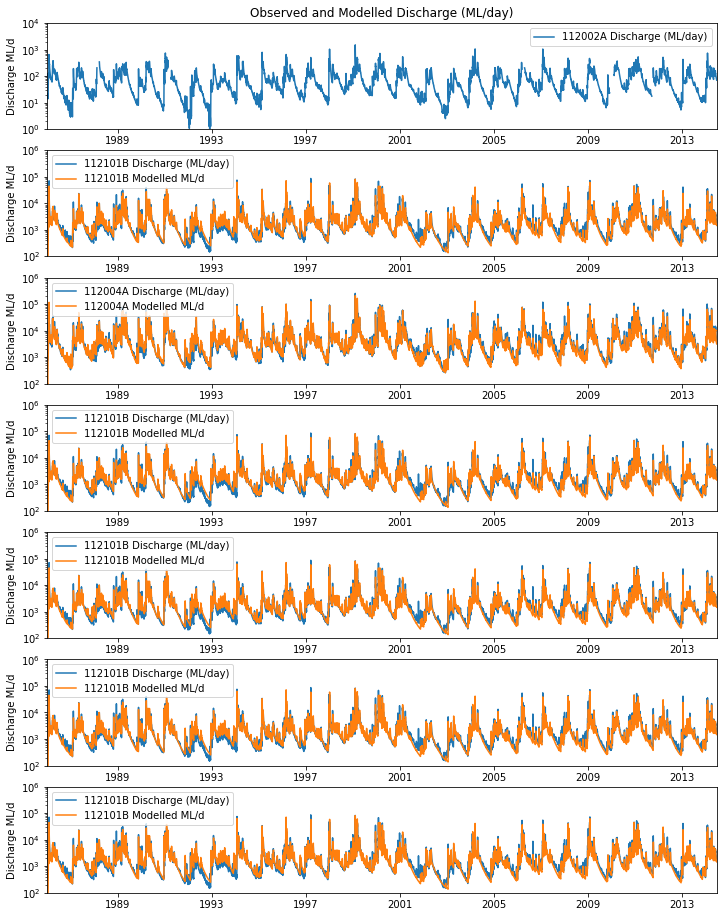

In [160]:
##Now we'll plot the same data, only in log scale this time'

plt.figure(figsize=(12,16))
plt.title('Observed Discharge (ML/day)')
plt.xlabel('Date')
plt.ylabel('Discharge ML/d')


#plt.figure(1)
ax1 = plt.subplot(711)
plt.semilogy(G112002A)
plt.title('Observed and Modelled Discharge (ML/day)')
plt.xlabel('Date')
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(1, 10000)
plt.xlim([1984, 2015])

ax2 = plt.subplot(712, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax3 = plt.subplot(713, sharex=ax1)
plt.semilogy(G112004A)
plt.semilogy(O112004A)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax4 = plt.subplot(714, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax5 = plt.subplot(715, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax6 = plt.subplot(716, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax7 = plt.subplot(717, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

plt.xlim("1986-01-01", "2014-06-30")


(733408.0, 735414.0)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


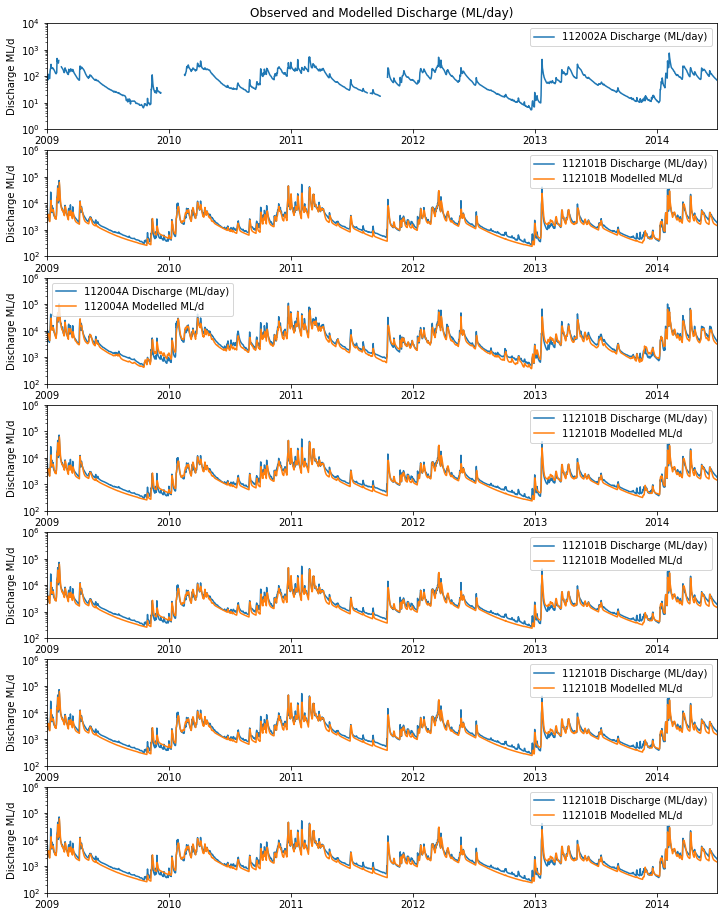

In [161]:
##Now we'll plot the same data, only in log scale and for a shorter period

plt.figure(figsize=(12,16))
plt.title('Observed Discharge (ML/day)')
plt.xlabel('Date')
plt.ylabel('Discharge ML/d')


#plt.figure(1)
ax1 = plt.subplot(711)
plt.semilogy(G112002A)
plt.title('Observed and Modelled Discharge (ML/day)')
plt.xlabel('Date')
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(1, 10000)
plt.xlim([1984, 2015])

ax2 = plt.subplot(712, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax3 = plt.subplot(713, sharex=ax1)
plt.semilogy(G112004A)
plt.semilogy(O112004A)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax4 = plt.subplot(714, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax5 = plt.subplot(715, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax6 = plt.subplot(716, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

ax7 = plt.subplot(717, sharex=ax1)
plt.semilogy(G112101B)
plt.semilogy(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()
plt.ylim(100, 1000000)

plt.xlim("2009-01-01", "2014-06-30")

(733408.0, 735414.0)

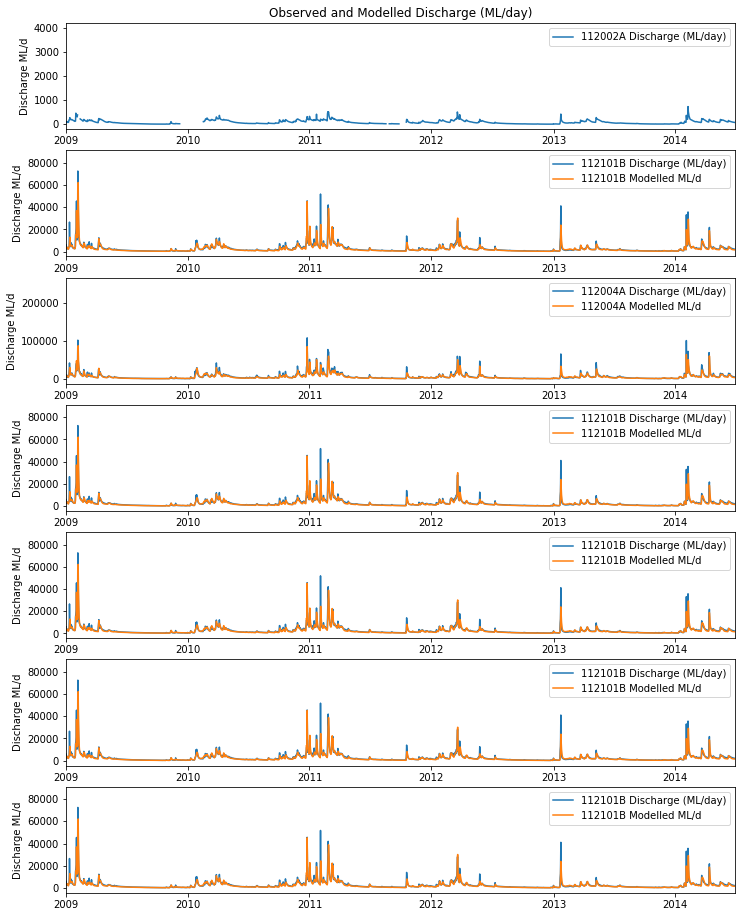

In [162]:
plt.figure(figsize=(12,16))
plt.title('Observed Discharge (ML/day)')
plt.xlabel('Date')
plt.ylabel('Discharge ML/d')

#plt.figure(1)
ax1 = plt.subplot(711)
plt.plot(G112002A)
plt.title('Observed and Modelled Discharge (ML/day)')
plt.xlabel('Date')
plt.ylabel('Discharge ML/d')
plt.legend()

ax2 = plt.subplot(712, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

ax3 = plt.subplot(713, sharex=ax1)
plt.plot(G112004A)
plt.plot(O112004A)
plt.ylabel('Discharge ML/d')
plt.legend()

ax4 = plt.subplot(714, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

ax5 = plt.subplot(715, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

ax6 = plt.subplot(716, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

ax7 = plt.subplot(717, sharex=ax1)
plt.plot(G112101B)
plt.plot(O112101B)
plt.ylabel('Discharge ML/d')
plt.legend()

plt.xlim("2009-01-01", "2014-06-30")

In [163]:
# now we will calculate the flow duration curves
# first we limit the observed data to the available modelled data period
Limited_obs=Obs_gauges.truncate('1986-01-01', '2014-06-30')

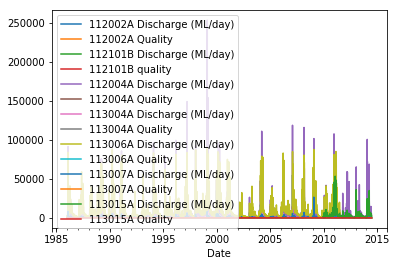

In [164]:
#Check that it has done what we thought it should
Limited_obs.plot()

In [165]:
def FlowDurationCurve(dfo,obs_site,dfm,mod_site,begyear,endyear):

#    Generate observed and modelled flow duration curve for hydrologic time series data
    
#    FlowDurationCurve = pandas dataframe containing data
#    Obs_site = column within dataframe that contains the observed flow values
#    Mod_site = column within dataframe that contains the modelled flow values
#    begyear = start year for analysis
#    endyear = end year for analysis

#trim the time series to beginning and end dates
    obsdata = dfo[(dfo.index.to_datetime() > pd.datetime(begyear,1,1))&(dfo.index.to_datetime() < pd.datetime(endyear,1,1))]
    moddata = dfm[(dfm.index.to_datetime() > pd.datetime(begyear,1,1))&(dfm.index.to_datetime() < pd.datetime(endyear,1,1))]

#remove na values from the observed data
    obsdata = obsdata[obs_site].dropna().values
    moddata = moddata[mod_site].dropna().values
    
# match the two time series to ensure thay are the same length??

#Sort and rank the observed and modelled data    
    obsdata = np.sort(obsdata)
    moddata = np.sort(moddata)
    
    obsranks = sp.rankdata(obsdata, method='average')
    obsranks = obsranks[::-1]

    modranks = sp.rankdata(moddata, method='average')
    modranks = modranks[::-1]

#calculate the probabilities    
    obsprob = [100*(obsranks[i]/(len(obsdata)+1)) for i in range(len(obsdata)) ]
    modprob = [100*(modranks[i]/(len(moddata)+1)) for i in range(len(moddata)) ]
    
#Plot the flow duration curves data    
    plt.figure(figsize=(12,6))
    plt.scatter(obsprob,obsdata,label=obs_site)
    plt.scatter(modprob,moddata,label=mod_site)
    plt.yscale('log')
    plt.grid(which = 'both')
    plt.xlabel('% of time that indicated discharge was exceeded or equaled')
    plt.ylabel('discharge (ML/d)')
    plt.xticks(range(0,100,5))
    plt.title('Flow duration curve for ' + obs_site)       
    
# output the data?? TBC

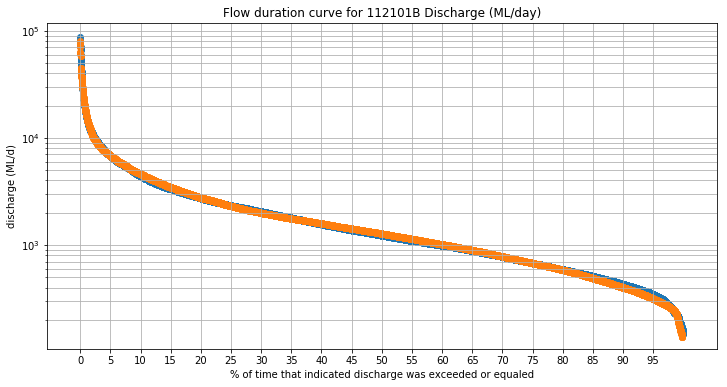

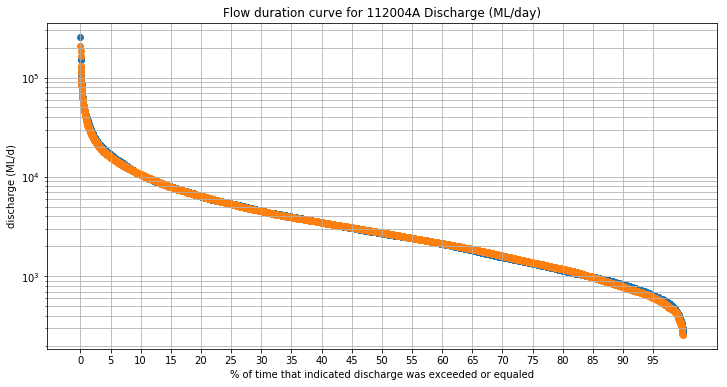

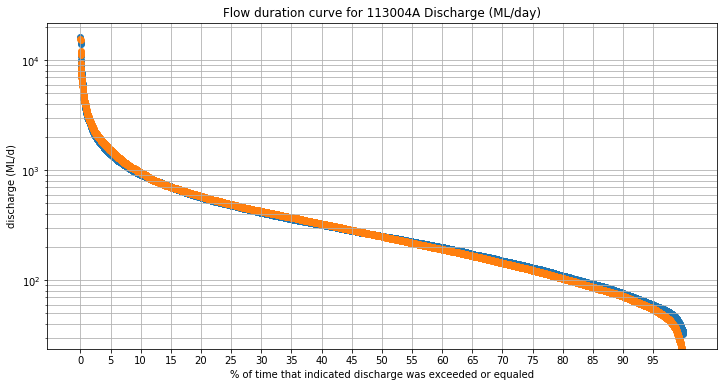

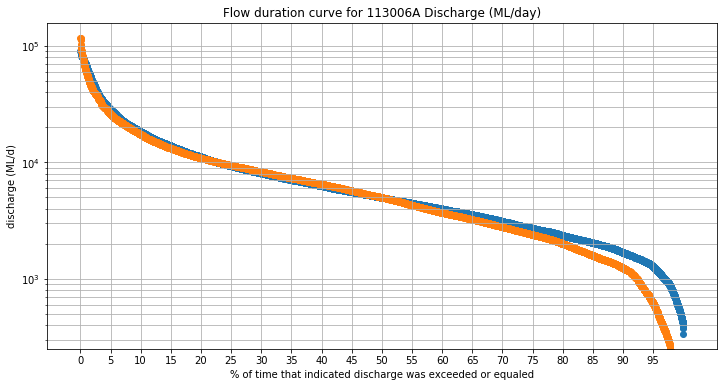

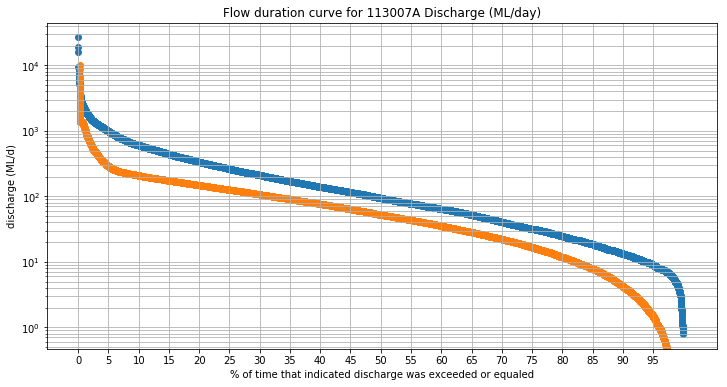

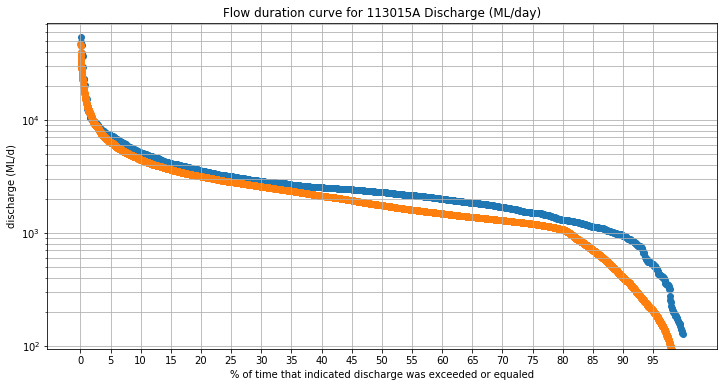

In [166]:
# Calculate and plot the modelled and measured flow duration curves

FlowDurationCurve(Obs_gauges,'112101B Discharge (ML/day)',Mod_gauges,'112101B Modelled ML/d',1986, 2014)
FlowDurationCurve(Obs_gauges,'112004A Discharge (ML/day)',Mod_gauges,'112004A Modelled ML/d',1986, 2014)
FlowDurationCurve(Obs_gauges,'113004A Discharge (ML/day)',Mod_gauges,'113004A Modelled ML/d',1986, 2014)
FlowDurationCurve(Obs_gauges,'113006A Discharge (ML/day)',Mod_gauges,'113006A Modelled ML/d',1986, 2014)
FlowDurationCurve(Obs_gauges,'113007A Discharge (ML/day)',Mod_gauges,'113007A Modelled ML/d',1986, 2014)
FlowDurationCurve(Obs_gauges,'113015A Discharge (ML/day)',Mod_gauges,'113015A Modelled ML/d',1986, 2014)


In [167]:
#def CorrelationStatistics(dfo,obs_site,dfm,mod_site,begyear,endyear):

#    Generate observed vs modelled correlation statistics 
    
#    CorrelationStatistics = pandas dataframe containing data

#    Obs_site = column within dataframe that contains the observed flow values
#    Mod_site = column within dataframe that contains the modelled flow values
#    begyear = start year for analysis
#    endyear = end year for analysis

#trim the time series to beginning and end dates
    #MD = MD[(MD.index.to_datetime() > pd.datetime(begyear,1,1))&(MD.index.to_datetime() < pd.datetime(endyear,1,1))]
    #obsdata = dfo[(dfo.index.to_datetime() > pd.datetime(begyear,1,1))&(dfo.index.to_datetime() < pd.datetime(endyear,1,1))]
    #moddata = dfm[(dfm.index.to_datetime() > pd.datetime(begyear,1,1))&(dfm.index.to_datetime() < pd.datetime(endyear,1,1))]

#match the data 
    #MD = obsdata.join(moddata)
    #MD = pd.merge(dfo[obs_site], dfm[mod_site], left_index=True)
    obsdata.describe()
    moddata.describe()
    
#remove na values from the observed data
    #obsdata = dfo[obs_site].dropna().values
    #moddata = dfm[mod_site].dropna().values
#    MD = MD.dropna().values

# Percent bias
#    percentbias = 100.0*sum(MD[moddata]-MD[obsdata])/sum(MD[obsdata])
#    abspercbias = 100.0*sum(abs(moddata-obsdata))/sum(obsdata)
#    DailyRMSE = np.sqrt(np.mean((moddata-obsdata)**2))
 #   DailyNSE = 1 - sum((moddata-obsdata)**2)/sum((obsdata-np.mean(obsdata))**2)

#convert to monthly data

#    print(percentbias)
#    print(abspercbias)
#    print(DailyRMSE)
#    print(DailyNSE)
    
    

IndentationError: unexpected indent (<ipython-input-167-ab5f57529eca>, line 14)

In [393]:
def CorrelationStats(dfo,obs_site,dfm,mod_site):

    #Compare modeleld and measured data

    #limit the analysis to the gauge in question
    dfo =dfo[obs_site]
    dfm =dfm[mod_site]
    
    #remove na values from the observed data
    dfa = dfo.dropna()   
    
    #Join the observed and modeled dataframes
    dfd = pd.concat([dfa, dfm], axis=1, join='inner')
    
    # Percent bias
    percentbias = 100.0*sum(dfd[mod_site]-dfd[obs_site])/sum(dfd[obs_site])
    abspercbias = 100.0*sum(abs(dfd[mod_site]-dfd[obs_site]))/sum(dfd[obs_site])
    DailyRMSE = np.sqrt(np.mean((dfd[mod_site]-dfd[obs_site])**2))
    DailyNSE = 1 - sum((dfd[mod_site]-dfd[obs_site])**2)/sum((dfd[obs_site]-np.mean(dfd[obs_site]))**2)

#convert to monthly data

    dfde = dfd.resample('M').mean()
    #remove na values from the observed data
    dfdm = dfde.dropna() 
    
    MonthlyRMSE = np.sqrt(np.mean((dfdm[mod_site]-dfdm[obs_site])**2))
    MonthlyNSE = 1 - sum((dfdm[mod_site]-dfdm[obs_site])**2)/sum((dfdm[obs_site]-np.mean(dfdm[obs_site]))**2)

#do cumulative plots
    dfdsum = dfd.cumsum()


    print(obs_site)
    print('percent bias =',round(percentbias,2))
    #    print(abspercbias)
    print('RMSE daily flows =',round(DailyRMSE,0))
    print('Daily Nash Sutcliffe Efficiency =',round(DailyNSE,3))
    print('RMSE Monthly flows =',round(MonthlyRMSE,0))
    print('Monthly Nash Sutcliffe Efficiency =',round(MonthlyNSE,3))
    print()
    
    plt.figure(figsize=(15,5))
    
    plt.plot(dfd[obs_site])
    plt.plot(dfd[mod_site])
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3 ,1)
    plt.scatter(dfd[obs_site],dfd[mod_site])

    plt.subplot(1, 3, 2)
    plt.scatter(dfdm[obs_site],dfdm[mod_site])
    
    plt.subplot(1, 3, 3)
    plt.scatter(dfdsum[obs_site],dfdsum[mod_site])
    #plt.scatter(obsprob,obsdata,label=obs_site)
    #plt.plot(dfdm[obs_site])
    #plt.plot(dfdm[mod_site])


112101B Discharge (ML/day)
percent bias = -1.34
RMSE daily flows = 1793.0
Daily Nash Sutcliffe Efficiency = 0.785
RMSE Monthly flows = 468.0
Monthly Nash Sutcliffe Efficiency = 0.961


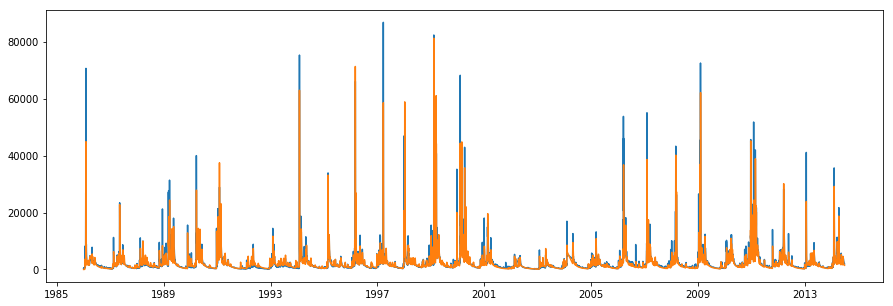

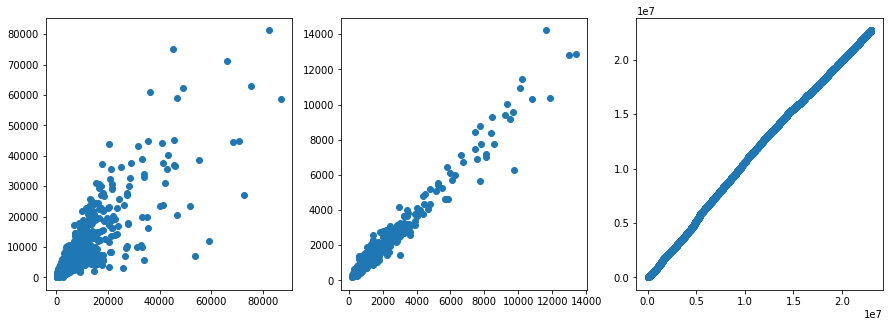

In [389]:
CorrelationStats(Obs_gauges,'112101B Discharge (ML/day)',Mod_gauges,'112101B Modelled ML/d')

112101B Discharge (ML/day)
percent bias = -1.34
RMSE daily flows = 1793.0
Daily Nash Sutcliffe Efficiency = 0.785
RMSE Monthly flows = 468.0
Monthly Nash Sutcliffe Efficiency = 0.961

112004A Discharge (ML/day)
percent bias = -1.87
RMSE daily flows = 3650.0
Daily Nash Sutcliffe Efficiency = 0.817
RMSE Monthly flows = 975.0
Monthly Nash Sutcliffe Efficiency = 0.968

113004A Discharge (ML/day)
percent bias = -0.94
RMSE daily flows = 421.0
Daily Nash Sutcliffe Efficiency = 0.68
RMSE Monthly flows = 145.0
Monthly Nash Sutcliffe Efficiency = 0.907

113006A Discharge (ML/day)
percent bias = -2.01
RMSE daily flows = 4363.0
Daily Nash Sutcliffe Efficiency = 0.85
RMSE Monthly flows = 2481.0
Monthly Nash Sutcliffe Efficiency = 0.911

113007A Discharge (ML/day)
percent bias = -56.25
RMSE daily flows = 502.0
Daily Nash Sutcliffe Efficiency = 0.31
RMSE Monthly flows = 326.0
Monthly Nash Sutcliffe Efficiency = 0.273

113015A Discharge (ML/day)
percent bias = -17.24
RMSE daily flows = 2356.0
Daily Na

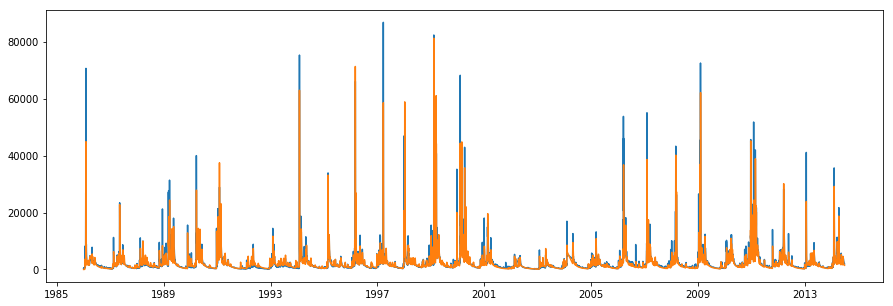

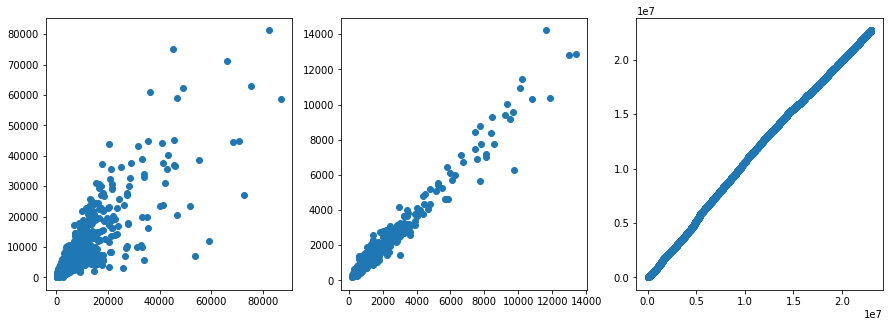

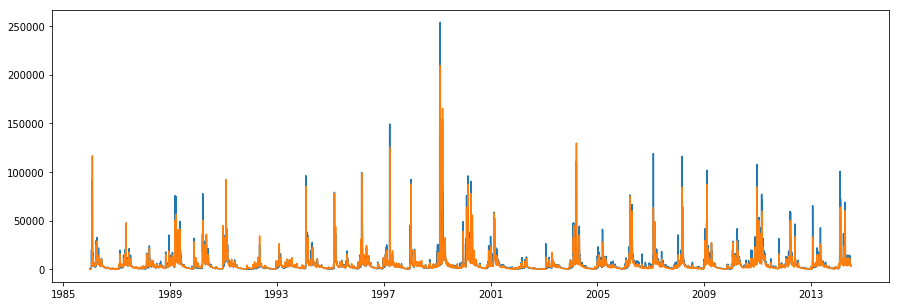

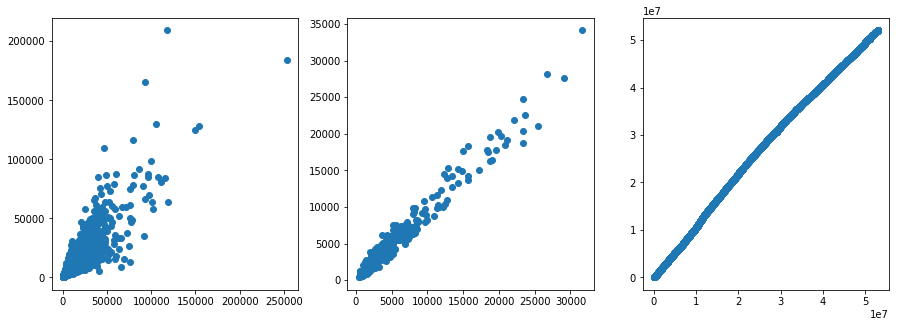

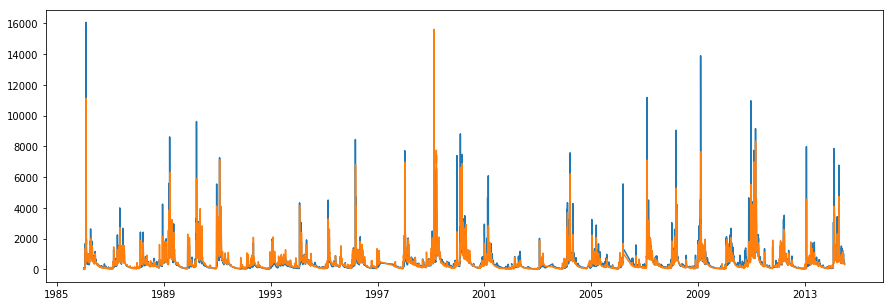

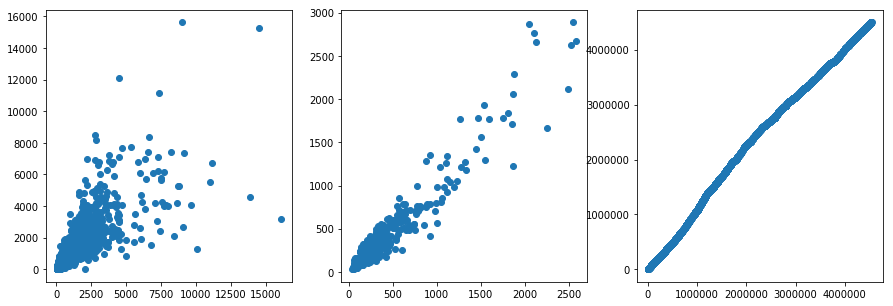

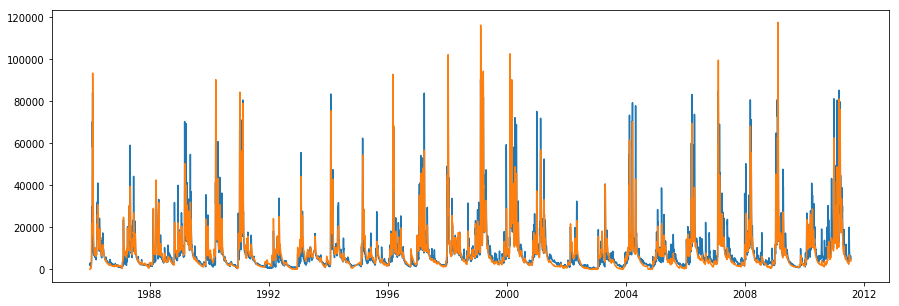

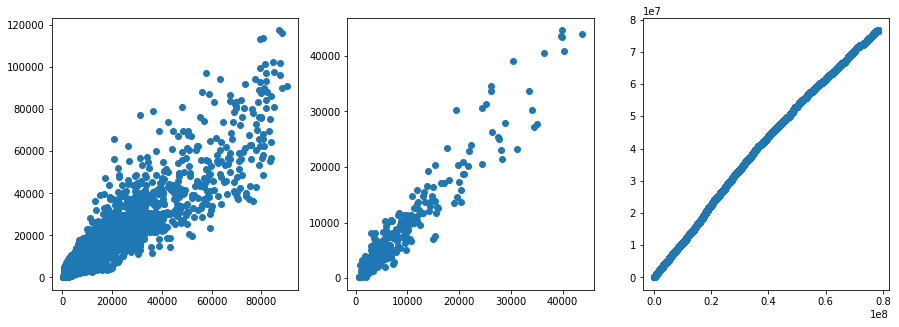

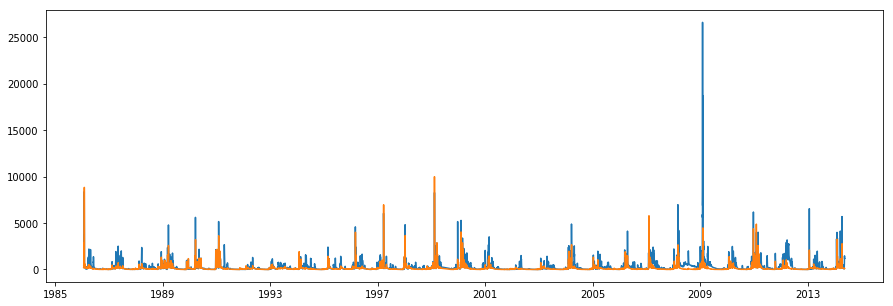

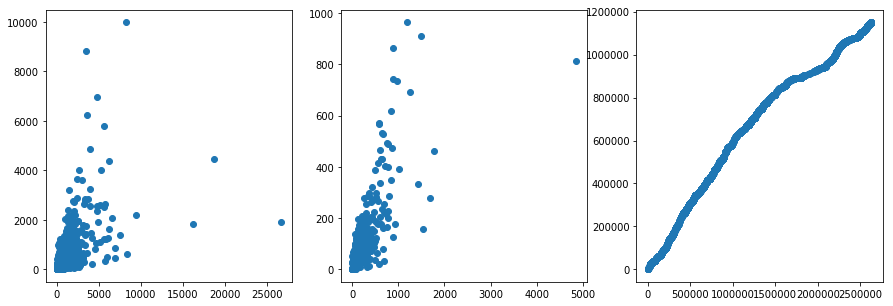

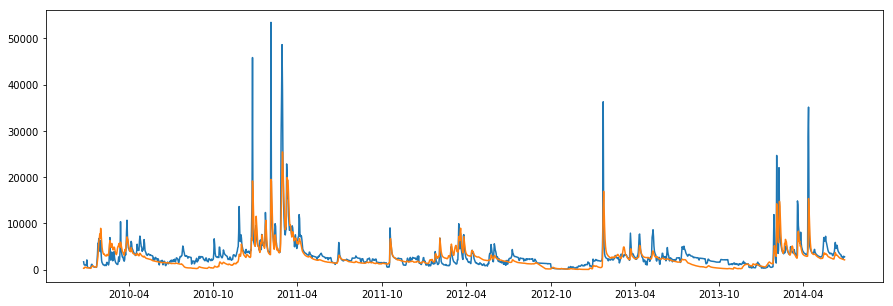

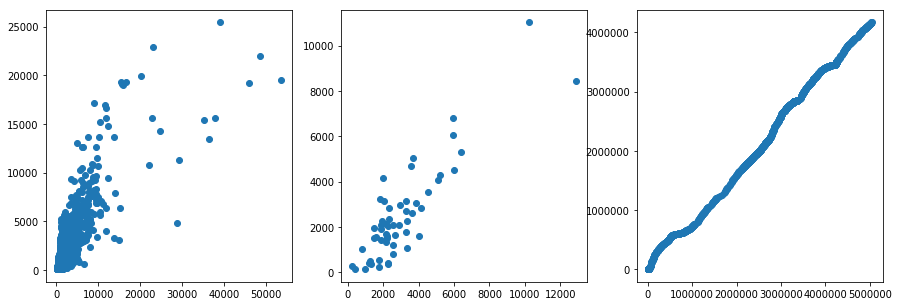

In [394]:
# Calculate and plot the modelled and measured daily statistics

CorrelationStats(Obs_gauges,'112101B Discharge (ML/day)',Mod_gauges,'112101B Modelled ML/d')
CorrelationStats(Obs_gauges,'112004A Discharge (ML/day)',Mod_gauges,'112004A Modelled ML/d')
CorrelationStats(Obs_gauges,'113004A Discharge (ML/day)',Mod_gauges,'113004A Modelled ML/d')
CorrelationStats(Obs_gauges,'113006A Discharge (ML/day)',Mod_gauges,'113006A Modelled ML/d')
CorrelationStats(Obs_gauges,'113007A Discharge (ML/day)',Mod_gauges,'113007A Modelled ML/d')
CorrelationStats(Obs_gauges,'113015A Discharge (ML/day)',Mod_gauges,'113015A Modelled ML/d')


In [ ]:
# next import subcatchment based sugarcane runoff totals - group by calibration region

In [ ]:
# load in spatial data with geopandas